# Split k-fold with class-balanced

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sys
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


In [3]:
annot_df = pd.read_csv('LUNA25_Public_Training_Development_Data_with_metadata.csv')
patient_df = pd.read_csv('LUNA25_Public_Training_Development_Data_Patient.csv')
annot_df.head()

,PatientID,SeriesInstanceUID,StudyDate,CoordX,CoordY,CoordZ,LesionID,AnnotationID,NoduleID,label,...,nodule_block_image_shape,x_origin,y_origin,z_origin,z_spacing,y_spacing,x_spacing,x_transform,y_transform,z_transform
0,100570,1.2.840.113654.2.55.32380467633296345717423514...,19990102,61.14,-163.28,-177.75,1,100570_1_19990102,100570_1,1,...,"(64, 128, 128)",-240.899994,-203.187500,21.312500,2.0,0.625000,0.625000,[1. 0. 0.],[0. 1. 0.],[0. 0. 1.]
1,106364,1.2.840.113654.2.55.16930993607533226779708566...,19990102,30.64,-95.96,-128.59,1,106364_1_19990102,106364_1,1,...,"(64, 128, 128)",-191.799988,-128.621094,-1.683594,2.0,0.507812,0.507812,[1. 0. 0.],[0. 1. 0.],[0. 0. 1.]
2,127302,1.2.840.113654.2.55.13728437630416839550344528...,20000102,-82.53,-27.85,-209.46,1,127302_1_20000102,127302_1,1,...,"(64, 128, 128)",-290.565002,-72.840622,-127.459381,2.5,0.703125,0.703125,[1. 0. 0.],[0. 1. 0.],[0. 0. 1.]
3,128899,1.2.840.113654.2.55.40415300708683206534849072...,20010102,-38.69,-8.78,-39.43,1,128899_1_20010102,128899_1,1,...,"(64, 128, 128)",-118.904999,-49.927383,-79.720345,2.5,0.644531,0.644531,[1. 0. 0.],[0. 1. 0.],[0. 0. 1.]
4,215816,1.3.6.1.4.1.14519.5.2.1.7009.9004.241362276021...,19990102,32.89,-37.98,-100.04,1,215816_1_19990102,215816_1,1,...,"(64, 128, 128)",-163.950012,-77.467155,-7.078842,2.0,0.621094,0.621094,[1. 0. 0.],[0. 1. 0.],[0. 0. 1.]


In [6]:
# groupby PatientID
print(len(annot_df['PatientID'].unique()))
source_col =['PatientID', 'StudyDate', 'label','Age_at_StudyDate', 'Gender', 'z_spacing']
censored_annot_df = annot_df[source_col]
print(len(censored_annot_df))
censored_annot_df.head()

2120
6163


,PatientID,StudyDate,label,Age_at_StudyDate,Gender,z_spacing
0,100570,19990102,1,63,Male,2.0
1,106364,19990102,1,67,Female,2.0
2,127302,20000102,1,61,Male,2.5
3,128899,20010102,1,64,Male,2.5
4,215816,19990102,1,69,Female,2.0


In [ ]:
# Group by PatientID
patient_df = annot_df.groupby('PatientID').agg(
    StudyDate=('StudyDate', lambda x: x.mode()[0]),
    malignancy=('label', lambda x: (x == 0).sum()),
    benign=('label', lambda x: (x == 1).sum()),
    Age_at_StudyDate=('Age_at_StudyDate', lambda x: x.mode()[0]),
    Gender=('Gender', lambda x: x.mode()[0]),  # 최빈값(가장 많이 등장한 성별)
    z_spacing_min=('z_spacing', 'min'),
    z_spacing_max=('z_spacing', 'max')
).reset_index()

print(len(patient_df))
patient_df.head()

2120


,PatientID,StudyDate,malignancy,benign,Age_at_StudyDate,Gender,z_spacing_min,z_spacing_max
0,100012,19990102,0,2,61,Female,2.0,2.0
1,100035,19990102,3,0,55,Female,2.5,2.5
2,100069,20000102,6,0,65,Female,2.0,2.0
3,100095,19990102,12,0,64,Male,2.0,2.0
4,100150,20000102,2,0,57,Male,2.0,2.0


In [11]:
patient_df['strat'] = patient_df['malignancy'].astype(str) + '_' + patient_df['benign'].astype(str)
patient_df.head()

,PatientID,StudyDate,malignancy,benign,Age_at_StudyDate,Gender,z_spacing_min,z_spacing_max,strat
0,100012,19990102,0,2,61,Female,2.0,2.0,0_2
1,100035,19990102,3,0,55,Female,2.5,2.5,3_0
2,100069,20000102,6,0,65,Female,2.0,2.0,6_0
3,100095,19990102,12,0,64,Male,2.0,2.0,12_0
4,100150,20000102,2,0,57,Male,2.0,2.0,2_0


<AxesSubplot:title={'center':'Histogram'}>

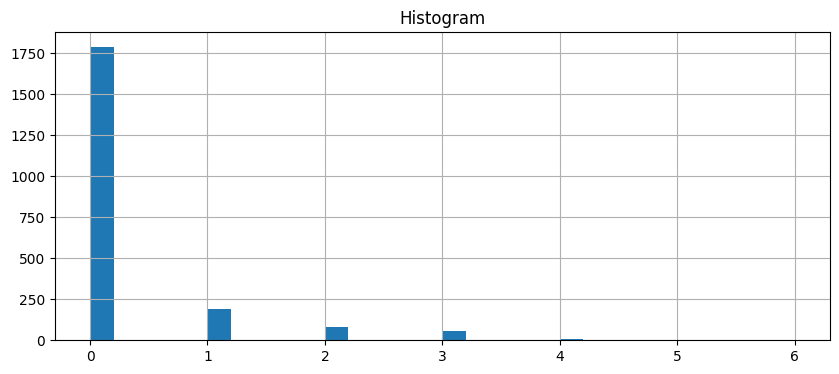

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Histogram")
patient_df.benign.hist(bins=30)

In [ ]:
# Split annot_df by PatientID: all samples from the same PatientID must be assigned to the same fold.
# StudyDate, label, gender, and z_spacing are well distributed across the dataset.
stratify = StratifiedKFold(n_splits=7, random_state=42, shuffle=True)

random_fold = {}
for i, (train_index, test_index) in enumerate(stratify.split(patient_df, patient_df['strat'])):
    random_fold.update({i: patient_df.iloc[test_index]['PatientID'].values})

/home/juho.jung/yes/envs/luna25/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=7.
  warnings.warn(


<AxesSubplot:title={'center':'Nodule Class Distribution with Nodule Type (Most count) & Average Size & Num Nodules'}, xlabel='label', ylabel='Count'>

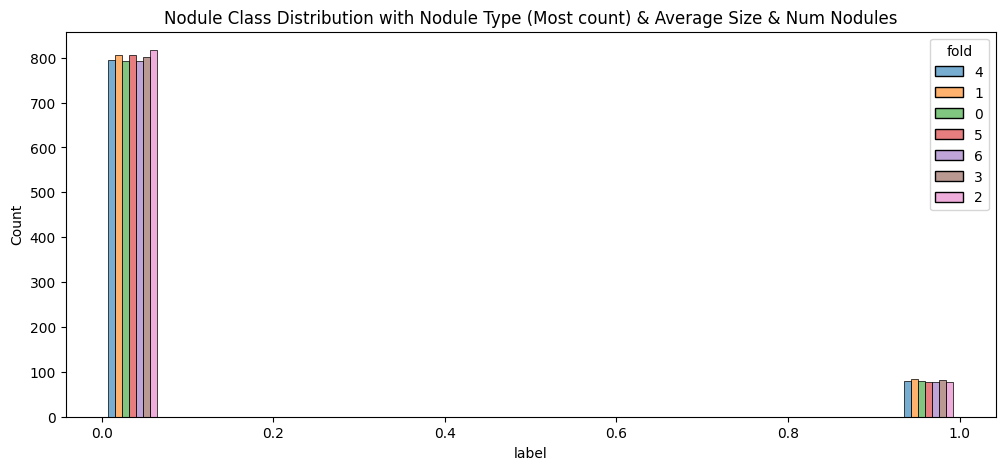

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Nodule Class Distribution with Nodule Type (Most count) & Average Size & Num Nodules", size="large")
tmp = annot_df.copy()
for fold_num, _idx in enumerate(random_fold.values()):
    tmp.loc[annot_df.PatientID.isin(_idx), "fold"] = str(fold_num)

sns.histplot(data=tmp, x="label", hue="fold", ax=ax, alpha=0.6, multiple="dodge", shrink=.8, legend=True)

<AxesSubplot:xlabel='StudyDate', ylabel='Count'>

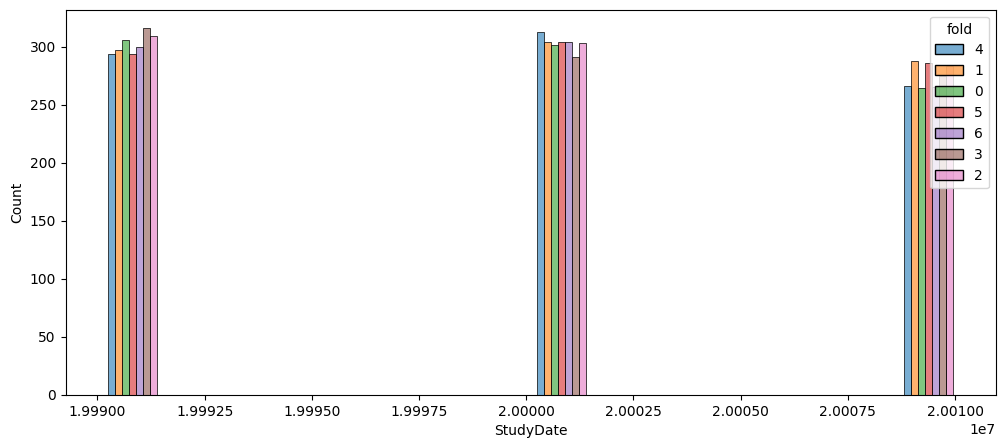

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=tmp, x="StudyDate", hue="fold", ax=ax, alpha=0.6, multiple="dodge", shrink=.8, legend=True)


<AxesSubplot:xlabel='z_spacing', ylabel='Count'>

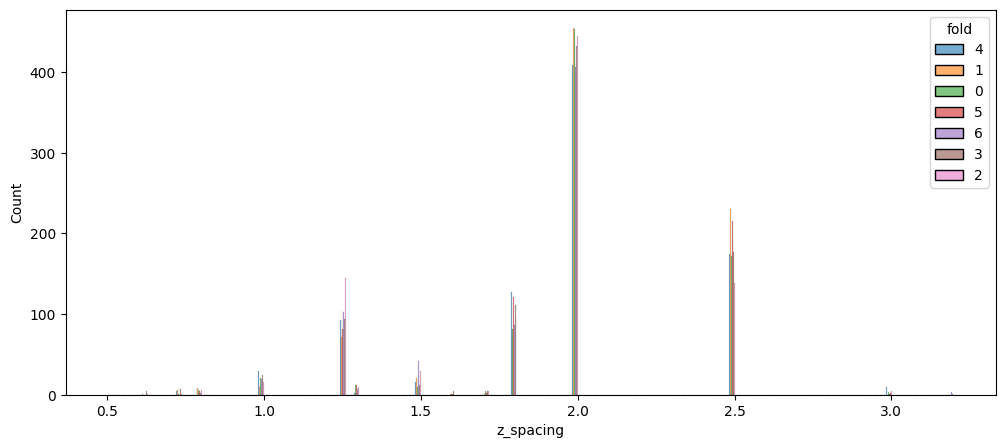

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=tmp, x="z_spacing", hue="fold", ax=ax, alpha=0.6, multiple="dodge", shrink=.8, legend=True)


<AxesSubplot:xlabel='Gender', ylabel='Count'>

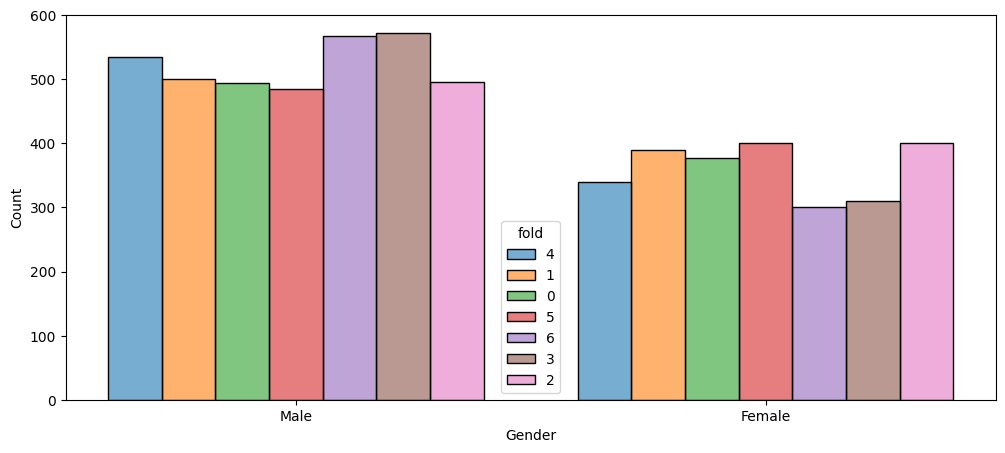

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=tmp, x="Gender", hue="fold", ax=ax, alpha=0.6, multiple="dodge", shrink=.8, legend=True)


<AxesSubplot:xlabel='Age_at_StudyDate', ylabel='Count'>

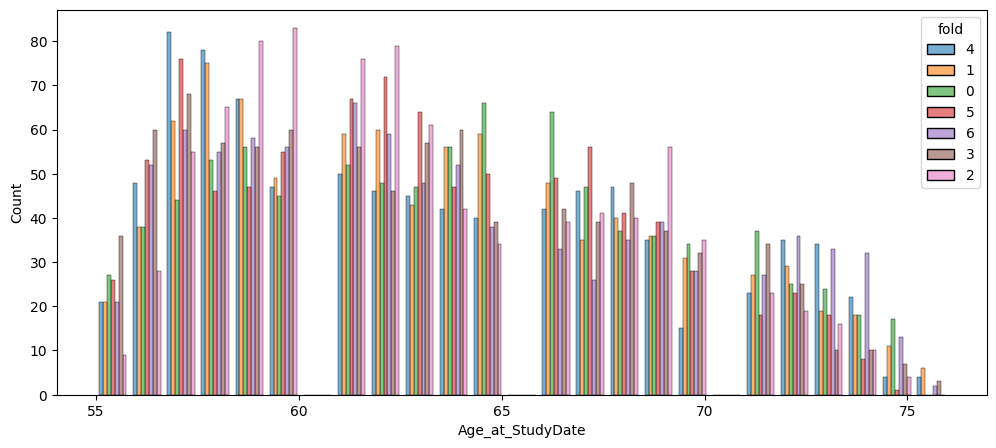

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=tmp, x="Age_at_StudyDate", hue="fold", ax=ax, alpha=0.6, multiple="dodge", shrink=.8, legend=True)

In [33]:
tmp['fold'].value_counts()

2    895
1    889
5    884
3    882
4    873
0    871
6    869
Name: fold, dtype: int64

In [34]:
tmp.to_csv('LUNA25_Public_Training_Development_Data_fold.csv', index=False)